TODO: 
- Średni wiek pacjentów przyjmowanych do ośrodków pomocy społecznej
- Średnia długość życia Polaków
- Dochody Polaków (czy rodziny będzie stać na prywatne domy opieki?)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
struktura_ludnosci = pd.ExcelFile('data/struktura_ludnosci.xls').parse(0)
struktura_ludnosci = struktura_ludnosci.drop([0, 1, 2, 4])
struktura_ludnosci = struktura_ludnosci.transpose()
struktura_ludnosci = struktura_ludnosci.reset_index().drop(columns=['index'])
struktura_ludnosci.columns = struktura_ludnosci.iloc[0]
struktura_ludnosci.drop(index=0, inplace=True)
struktura_ludnosci = struktura_ludnosci.set_index('Grupy wieku')
struktura_ludnosci.index.names = ['Rok']
struktura_ludnosci.index = struktura_ludnosci.index.astype(np.int64)
struktura_ludnosci = struktura_ludnosci.loc[:, :'Kobiety w wieku rozrodczym 15 - 49 lat          ']
struktura_ludnosci.rename(columns=lambda x: str(x).strip(), inplace=True)

In [3]:
def plot_pop_and_save(columns, figtitle, filename):
    plot_data = struktura_ludnosci[columns]
    fig, ax = plt.subplots()
    ax.set_title(figtitle)
    for column in plot_data.columns:
        ax.plot(plot_data.index, plot_data[column])
    plt.legend(plot_data.columns, loc='best')
    ax.set_xlabel('Rok')
    ax.set_ylabel('Liczba ludności (w tys.)')
    ax.grid()
    plt.show()
    fig.savefig('img/{}'.format(filename))

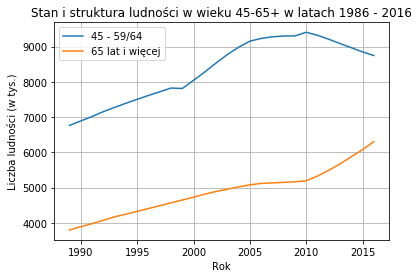

In [4]:
plot_pop_and_save(
    ['45 - 59/64', '65 lat i więcej'], 
    'Stan i struktura ludności w wieku 45-65+ w latach 1986 - 2016', 
    'struktura_ludnosci.jpg'
)

Możemy jednocześnie sprawdzić stan młodszych grup wiekowych, aby móc mniej więcej zaprognozować stan wyższych grup wiekowych w przyszłości

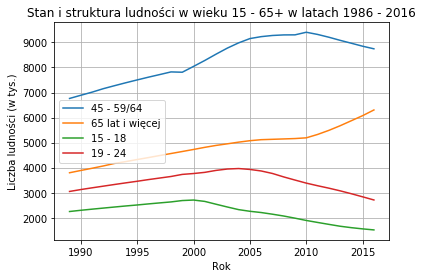

In [5]:
plot_pop_and_save(
    ['45 - 59/64', '65 lat i więcej', '15 - 18', '19 - 24'],
    'Stan i struktura ludności w wieku 15 - 65+ w latach 1986 - 2016',
    'struktura_ludnosci_2.jpg'   
)

In [6]:
struktura_ludnosci['udzial_kobiet_w_wieku_rozrodczym'] = struktura_ludnosci['Kobiety w wieku rozrodczym 15 - 49 lat'] / struktura_ludnosci['OGÓŁEM']

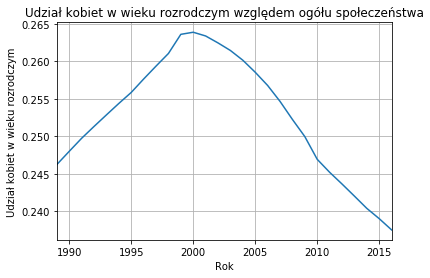

In [7]:
ax = struktura_ludnosci['udzial_kobiet_w_wieku_rozrodczym'].plot(title='Udział kobiet w wieku rozrodczym względem ogółu społeczeństwa')
ax.set_ylabel('Udział kobiet w wieku rozrodczym');
ax.grid();
plt.show()

Jak widać na przedstawionym wyżej wykresie, liczba ludności w wieku 65+ przez najbliższy czas wydaje się wykazywać trend wzrostowy, jednak patrząc na liczebność młodszych pokoleń, możemy spodziewać się gwałtownego spadku wśród liczebności populacji seniorów. Nie stanowi to jednak jeszcze przesłanki do wysunięcia wniosku, że otwieranie nowych placówek prywatnej opieki społecznej jest złą inwestycją. Aby bardziej szczegółowo zbadać to zagadnienie, warto byłoby przyjrzeć się bliżej zmianom społecznym i obyczajowym, które na przestrzeni lat stają się coraz bardziej widoczne, współczynnikowi urodzeń, oraz obecnej "pojemności" placówek, zarówno prywatnych jak i publicznych.

In [8]:
uro = pd.read_csv('data/urodzenia_zywe.csv', sep=';')

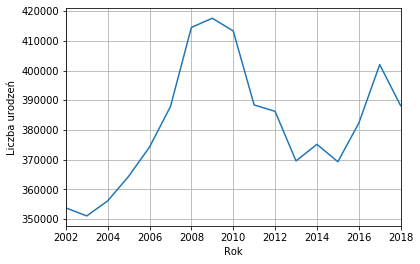

In [9]:
uro.drop(['Kod', 'Nazwa', 'Wiek matki', 'Jednostka miary', 'Atrybut', 'Unnamed: 7'], axis=1).plot('Rok', 'Wartosc', legend=False);
plt.ylabel('Liczba urodzeń');
plt.grid()
plt.savefig('img/liczba_urodzen.png', dpi=300)

In [10]:
wsp_dziet = pd.read_csv('data/wspolczynnik_dzietnosci.csv', sep=';')

In [11]:
wsp_dziet.drop(['Kod', 'Nazwa', 'Jednostka miary', 'Atrybut', 'Unnamed: 7'], inplace=True, axis=1)

In [12]:
wsp_dziet['Wartosc'] = wsp_dziet['Wartosc'].apply(lambda x: float(x.replace(',', '.')))

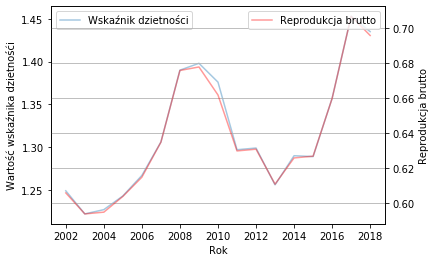

In [13]:
dziet_plot_data = wsp_dziet[wsp_dziet['Współczynniki'] == 'dzietność'].drop('Współczynniki', axis=1)
rep_brutto = wsp_dziet[wsp_dziet['Współczynniki'] == 'reprodukcja brutto'].drop('Współczynniki', axis=1)

fig, ax = plt.subplots()
ax.plot(dziet_plot_data['Rok'], dziet_plot_data['Wartosc'], alpha=.4, label='Wskaźnik dzietności')
ax.set_xlabel('Rok')
ax.set_ylabel('Wartość wskaźnika dzietnośći')
ax.legend(loc='best')

ax2 = ax.twinx()
ax2.plot(rep_brutto['Rok'], rep_brutto['Wartosc'], color='red', alpha=.4, label='Reprodukcja brutto')
ax2.set_ylabel('Reprodukcja brutto')
ax2.set_xlabel('Rok')
ax2.legend(loc='upper right')
plt.grid()
fig.savefig('img/wsk_dzien_vs_repr_brutto.png')

plt.show()

In [14]:
dzietnosc = pd.ExcelFile('data/dzietnosc_kobiet.xls').parse(0)
old_col_names = dzietnosc.columns
new_col_names = ['year', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', 'fertility_rate', 'median_age_first_child', 'mean_age', 'mean_age_first_child']
colnames = dict(zip(old_col_names, new_col_names))
dzietnosc.rename(columns=colnames, inplace=True)
dzietnosc = dzietnosc.iloc[4:-3]
dzietnosc.replace('...', np.nan, inplace=True)
dzietnosc.set_index('year', inplace=True)

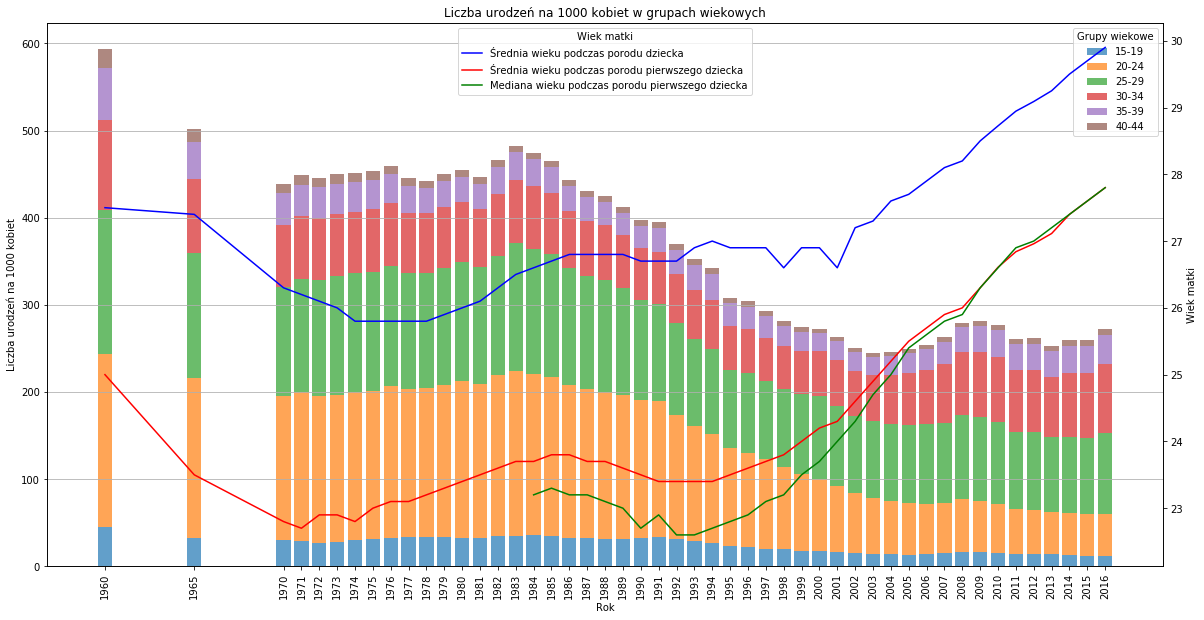

In [15]:
age_groups = dzietnosc.columns[:-5]
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.set_xticklabels(dzietnosc.index, rotation=90)
ax.set_xticks(dzietnosc.index)
ax.set_title('Liczba urodzeń na 1000 kobiet w grupach wiekowych')
ax.set_xlabel('Rok')
ax.set_ylabel('Liczba urodzeń na 1000 kobiet')
for i in range(len(age_groups)):
    ax.bar(dzietnosc.index, dzietnosc[age_groups[i]], label=age_groups[i], bottom=np.array(dzietnosc[age_groups[:i]].sum(axis=1)), alpha=.7)

ax.legend(title='Grupy wiekowe')
ax.yaxis.grid()
ax2 = ax.twinx()
ax2.set_ylabel('Wiek matki')
ax2.plot(dzietnosc['mean_age'], color='blue', label='Średnia wieku podczas porodu dziecka')
ax2.plot(dzietnosc['mean_age_first_child'], color='red', label='Średnia wieku podczas porodu pierwszego dziecka')
ax2.plot(dzietnosc['median_age_first_child'], color='green', label='Mediana wieku podczas porodu pierwszego dziecka')
ax2.legend(title='Wiek matki', loc='upper center')

fig.savefig('img/liczba_urodzen_na_1000_kobiet.png')
plt.show()

Na wykresie powyżej widać, że kobiety rodzą coraz mniej dzieci oraz robią to w coraz późniejszym momencie swojego życia. Można z tego wywnioskować, że w dalszej przyszłości niż demograficzny może być problemem dla ośrodków pomocy społecznej. Byłby to jednak wniosek wysnuty na podstawie niepełnych informacji. Warto dodatkowo przyjrzeć się średniej długości życia w Polsce oraz jej prognozom.

Dodatkowo pooczątki niżu demograficznego możemy zaobserwować na początku lat 90-tych. We wcześniejszych rocznikach obserwowano dużo większą liczbę urodzeń i właśnie te roczniki mogą stanowić grupę docelową w bliższej przyszłości (np. ludność urodzona w latach 1960-1965)

In [93]:
list(set(list(zip(*prog.index))[0]))

[2050, 2019, 2020, 2025, 2030, 2035, 2040, 2045]

In [77]:
prog = pd.read_csv('data/prognoza_ludnosci.csv', sep=';').drop(columns=['Unnamed: 10', 'Atrybut', 'Jednostka miary', 'Płeć', 'Miejsce zamieszkania', 'Nazwa', 'Kod', 'Rok'])
prog['Rok'] = prog['Prognoza na rok'].apply(lambda x: int(x.split(' ')[-1]))
prog.drop(columns=['Prognoza na rok'], inplace=True)
prog.set_index(['Rok', 'Wiek'], inplace=True)

In [79]:
prog.index.unique()

MultiIndex([(2019,         '0-4'),
            (2019,         '5-9'),
            (2019,       '10-14'),
            (2019,       '15-19'),
            (2019,       '20-24'),
            (2019,       '25-29'),
            (2019,       '30-34'),
            (2019,       '35-39'),
            (2019,       '40-44'),
            (2019,       '45-49'),
            ...
            (2050,       '40-44'),
            (2050,       '45-49'),
            (2050,       '50-54'),
            (2050,       '55-59'),
            (2050,       '60-64'),
            (2050,       '65-69'),
            (2050,       '70-74'),
            (2050,       '75-79'),
            (2050,       '80-84'),
            (2050, '85 i więcej')],
           names=['Rok', 'Wiek'], length=144)

TypeError: float() argument must be a string or a number, not 'NoneType'

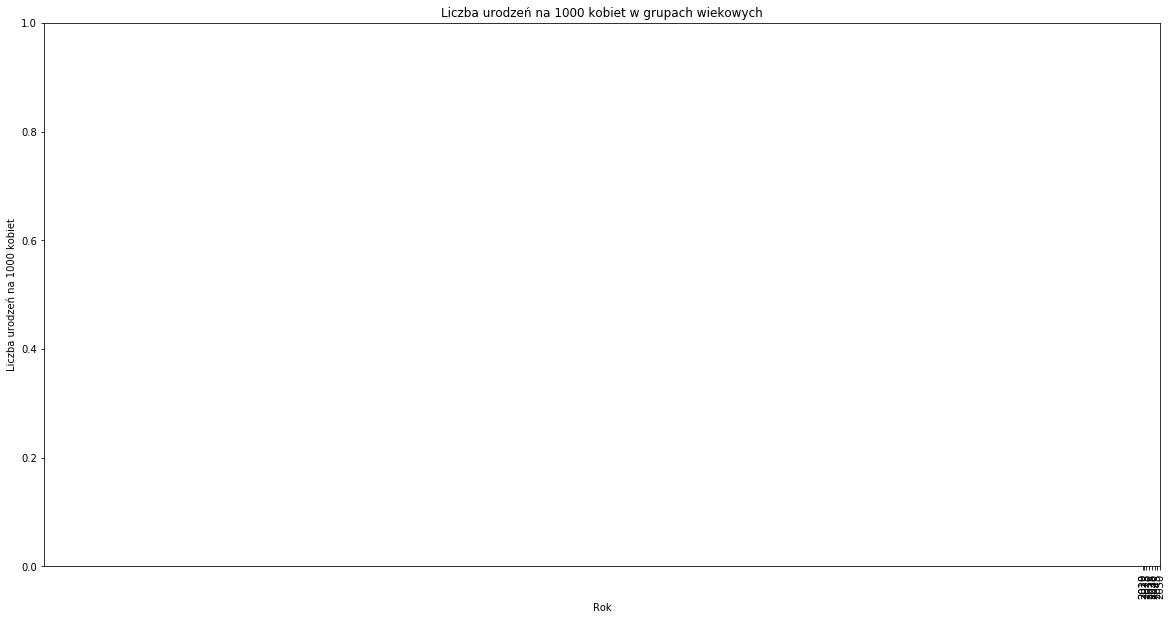

In [94]:
years = list(set(list(zip(*prog.index))[0]))
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.set_xticklabels(years, rotation=90)
ax.set_xticks(years)
ax.set_title('Liczba urodzeń na 1000 kobiet w grupach wiekowych')
ax.set_xlabel('Rok')
ax.set_ylabel('Liczba urodzeń na 1000 kobiet')
for i in prog.index:
    ax.bar(prog.loc[i[0]], prog.loc[i, 'Wartosc'], label=i[1])

ax.legend(title='Grupy wiekowe')
ax.yaxis.grid()
ax2 = ax.twinx()
ax2.set_ylabel('Wiek matki')
ax2.plot(prog['mean_age'], color='blue', label='Średnia wieku podczas porodu dziecka')
ax2.plot(prog['mean_age_first_child'], color='red', label='Średnia wieku podczas porodu pierwszego dziecka')
ax2.plot(prog['median_age_first_child'], color='green', label='Mediana wieku podczas porodu pierwszego dziecka')
ax2.legend(title='Wiek matki', loc='upper center')

fig.savefig('img/liczba_urodzen_na_1000_kobiet.png')
plt.show()

In [35]:
prog

,Wiek,Wartosc,Rok
0,0-4,1743580,2019
1,5-9,1926366,2019
2,10-14,2016357,2019
3,15-19,1801948,2019
4,20-24,2032897,2019
...,...,...,...
139,65-69,2875348,2050
140,70-74,2605358,2050
141,75-79,2079284,2050
142,80-84,1465684,2050


In [16]:
zakl_op_lecz = pd.read_csv('data/zaklady_opiekunczo_lecznicze.csv', sep=';')
zakl_op_lecz.drop(columns=['Nazwa', 'Kod', 'Jednostka miary', 'Atrybut', 'Unnamed: 7'], inplace=True)
zakl_op_lecz.set_index(['Wykaz'], inplace=True)
zakl_op_lecz['Rok'] = zakl_op_lecz['Rok'].astype(np.int64)

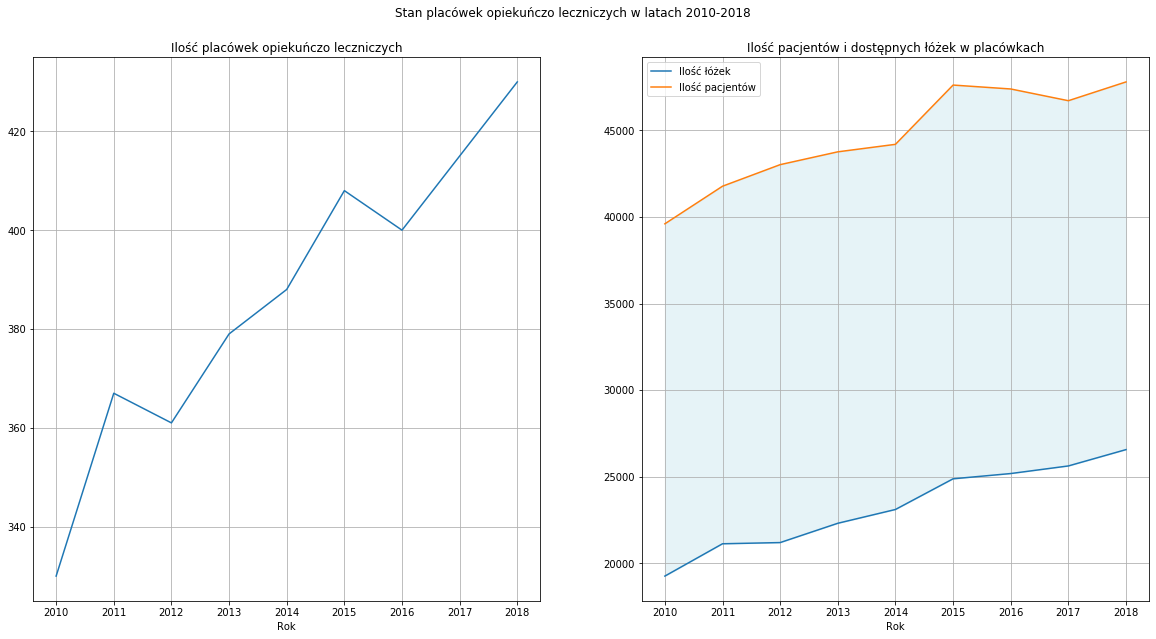

In [17]:
fig, ax = plt.subplots(1, 2)
fig.suptitle('Stan placówek opiekuńczo leczniczych w latach 2010-2018', y=.95)
ax[0].grid()
ax[0].plot(zakl_op_lecz.loc['ogółem']['Rok'], zakl_op_lecz.loc['ogółem']['Wartosc'])
ax[0].set_xlabel('Rok')
ax[0].set_title('Ilość placówek opiekuńczo leczniczych')
ax[1].plot(zakl_op_lecz.loc['łóżka stan w dniu 31.12']['Rok'], zakl_op_lecz.loc['łóżka stan w dniu 31.12']['Wartosc'], label='Ilość łóżek')
ax[1].set_title('Ilość pacjentów i dostępnych łóżek w placówkach')
ax[1].set_xlabel('Rok')
ax[1].plot(zakl_op_lecz.loc['pacjenci']['Rok'], zakl_op_lecz.loc['pacjenci']['Wartosc'], label='Ilość pacjentów')
ax[1].fill_between(zakl_op_lecz.loc['pacjenci']['Rok'], zakl_op_lecz.loc['łóżka stan w dniu 31.12']['Wartosc'], zakl_op_lecz.loc['pacjenci']['Wartosc'], alpha=.3, color='lightblue')
ax[1].legend()
ax[1].grid()
fig.set_size_inches(20, 10)
fig.savefig('img/pl_op_lecz.png')

Można policzyć ile średnio przypada łóżek i pacjentów na placówkę i ile łóżek brakuje

In [18]:
zakl_piel_op = pd.read_csv('data/zaklady_pielegnacyjno_opiekuncze.csv', sep=';')
zakl_piel_op.drop(columns=['Nazwa', 'Kod', 'Jednostka miary', 'Atrybut', 'Unnamed: 7'], inplace=True)
zakl_piel_op.set_index(['Wykaz'], inplace=True)
zakl_piel_op['Rok'] = zakl_piel_op['Rok'].astype(np.int64)
zakl_piel_op = zakl_piel_op[zakl_piel_op['Rok'] >= 2010]

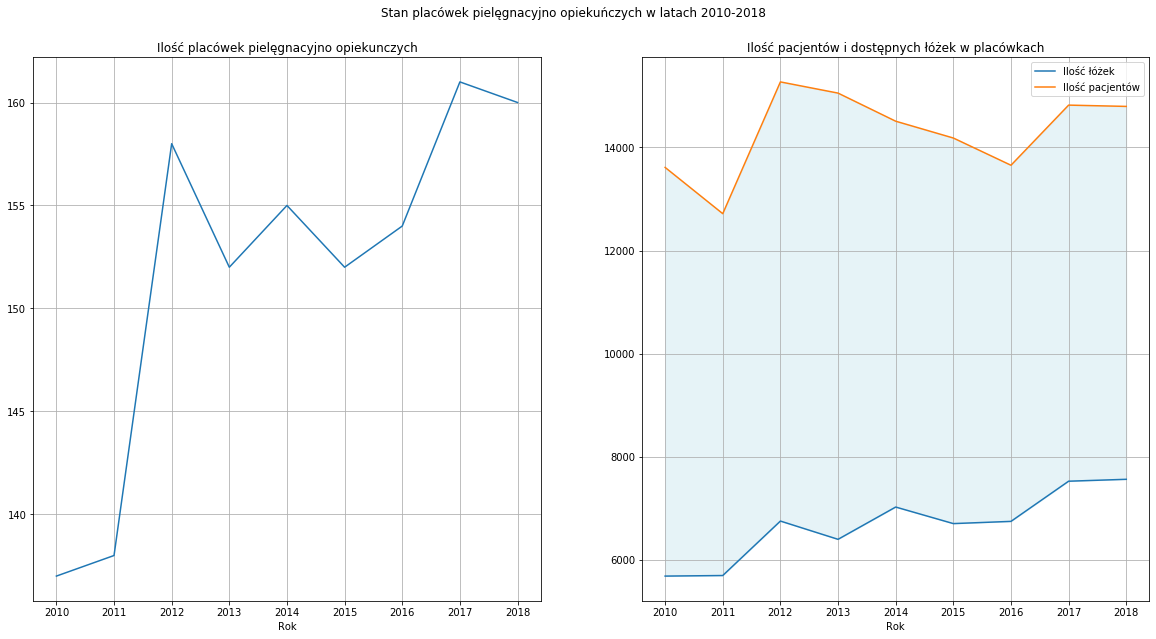

In [19]:
fig, ax = plt.subplots(1, 2)
fig.suptitle('Stan placówek pielęgnacyjno opiekuńczych w latach 2010-2018', y=.95)
ax[0].grid()
ax[0].plot(zakl_piel_op.loc['ogółem']['Rok'], zakl_piel_op.loc['ogółem']['Wartosc'])
ax[0].set_xlabel('Rok')
ax[0].set_title('Ilość placówek pielęgnacyjno opiekunczych')
ax[1].plot(zakl_piel_op.loc['łóżka stan w dniu 31.12']['Rok'], zakl_piel_op.loc['łóżka stan w dniu 31.12']['Wartosc'], label='Ilość łóżek')
ax[1].set_title('Ilość pacjentów i dostępnych łóżek w placówkach')
ax[1].set_xlabel('Rok')
ax[1].plot(zakl_piel_op.loc['pacjenci']['Rok'], zakl_piel_op.loc['pacjenci']['Wartosc'], label='Ilość pacjentów')
ax[1].fill_between(zakl_piel_op.loc['pacjenci']['Rok'], zakl_piel_op.loc['łóżka stan w dniu 31.12']['Wartosc'], zakl_piel_op.loc['pacjenci']['Wartosc'], alpha=.3, color='lightblue')
ax[1].legend()
ax[1].grid()
fig.set_size_inches(20, 10)
fig.savefig('img/pl_piel_op.png')

Pomimo wzrostu ilości placówek, ilość pacjentów bez przydzielonego miejsca nadal pozostaje na podobnym poziomie

In [20]:
life_exp = pd.read_csv('data/przecietne_dalsze_trwanie_zycia.csv', sep=';').drop(columns=['Kod', 'Nazwa', 'Lokalizacje', 'Jednostka miary', 'Atrybut', 'Unnamed: 9']).set_index(['Płeć']).dropna()
life_exp['Wartosc'] = life_exp['Wartosc'].apply(lambda x: float(x.replace(',', '.')))

In [21]:
life_exp['Wiek'].unique()

array([ 0, 15, 30, 45, 60, 65])

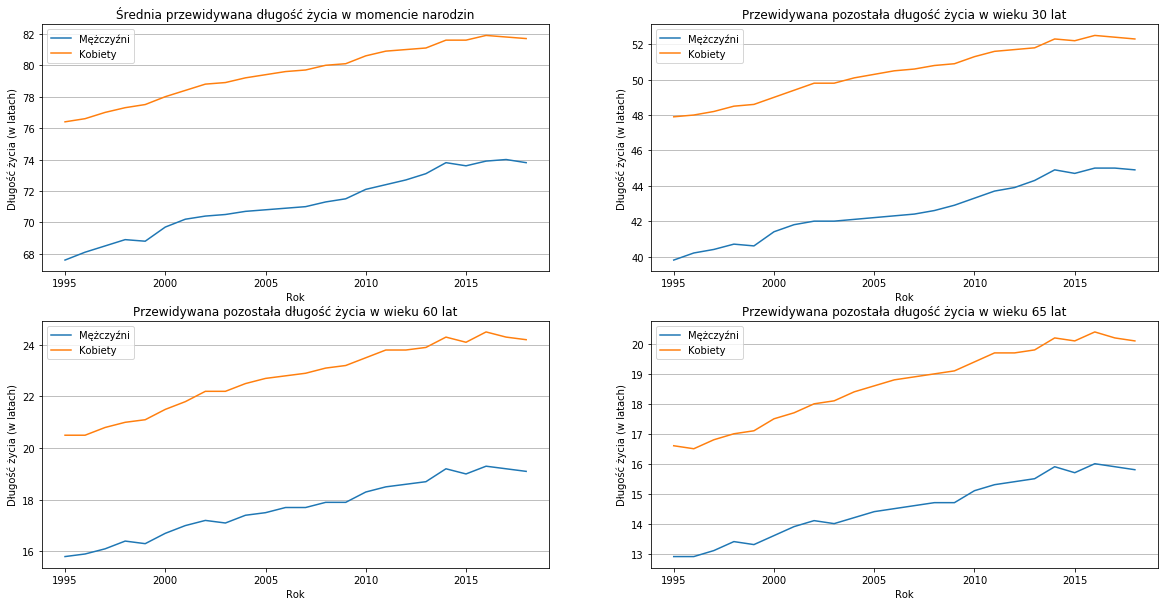

In [22]:
fig, ax = plt.subplots(2, 2);
fig.set_size_inches(20, 10);
ax = ax.flatten();

for age in enumerate([0, 30, 60, 65]):
    plt_data = life_exp[life_exp['Wiek'] == age[1]]
    ax[age[0]].plot(plt_data.loc['mężczyźni', 'Rok'], plt_data.loc['mężczyźni', 'Wartosc'], label='Mężczyźni')
    ax[age[0]].plot(plt_data.loc['kobiety', 'Rok'], plt_data.loc['kobiety', 'Wartosc'], label='Kobiety')
    ax[age[0]].legend()
    ax[age[0]].set_title('Średnia przewidywana długość życia w momencie narodzin' if age[1] == 0 else 'Przewidywana pozostała długość życia w wieku {} lat'.format(age[1]))
    ax[age[0]].set_xlabel('Rok')
    ax[age[0]].set_ylabel('Długość życia (w latach)')
    ax[age[0]].yaxis.grid()
    
fig.savefig('img/life_exp.png')